In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


!cp "/content/gdrive/My Drive/corrected_slices_v2.zip" .
!unzip -qq corrected_slices_v2.zip
!rm corrected_slices_v2.zip
data_path = 'corrected_slices_v2'

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Masking
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error
import joblib

BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 5e-4
PLOT_SAVE_DIR = 'predicted_vs_actual_plots_dynamic'

def process_file(file_path):
    df = pd.read_csv(file_path)
    df['time'] = df['time'] - df['time'].iloc[0]
    df['Momentary Coolant change rate'] = df['Coolant_temperature'].diff().fillna(0)
    features = df[['Engine_speed', 'Throttle_position', 'Accelerator_pedal_position']]
    target = df['Momentary Coolant change rate']
    return features.values, target.values

def pad_and_normalize(data, scaler, sequence_length):
    padded_data = pad_sequences(data, maxlen=sequence_length, dtype='float32', padding='post', truncating='post')
    normalized_data = scaler.transform(padded_data.reshape(-1, padded_data.shape[-1])).reshape(padded_data.shape)
    return normalized_data

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_original = []
y_original = []
sequence_lengths = []

data_path = 'corrected_slices'
for file_name in os.listdir(data_path):
    file_path = os.path.join(data_path, file_name)
    X, y = process_file(file_path)
    X_original.append(X)
    y_original.append(y)
    sequence_lengths.append(len(X))

# Fit the scaler on the concatenated data for normalization
scaler_X.fit(np.vstack(X_original))
scaler_y.fit(np.hstack(y_original).reshape(-1, 1))

# Normalize the data
X_normalized = [scaler_X.transform(x) for x in X_original]
y_normalized = [scaler_y.transform(y.reshape(-1, 1)).flatten() for y in y_original]

# Find the maximum sequence length
max_sequence_length = max(sequence_lengths)
print(max_sequence_length)

# Pad the sequences to the maximum length
X_padded = pad_sequences(X_normalized, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')
y_padded = pad_sequences(y_normalized, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Convert to numpy arrays
X_padded = np.array(X_padded)
y_padded = np.array(y_padded)

# Reshape y to be 3D
y_padded = y_padded.reshape((y_padded.shape[0], y_padded.shape[1], 1))

# Split into train and test sets
split_idx = int(0.8 * len(X_padded))
X_train, X_test = X_padded[:split_idx], X_padded[split_idx:]
y_train, y_test = y_padded[:split_idx], y_padded[split_idx:]

# Define the model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_sequence_length, X_train.shape[2])),
    Bidirectional(LSTM(100, return_sequences=True)),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

# Evaluate the model
y_pred = model.predict(X_test)

# Reverse normalization
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

# Calculate the error
mse = mean_squared_error(y_test_rescaled.flatten(), y_pred_rescaled.flatten())
print(f"Mean Squared Error: {mse}")

# Save the model
model.save('modelBLSTM_lightoff_dynamic.h5')

1363
Epoch 1/50
15/15 [==============================] - 88s 5s/step - loss: 0.0090 - val_loss: 0.0049
Epoch 2/50
15/15 [==============================] - 79s 5s/step - loss: 0.0048 - val_loss: 0.0042
Epoch 3/50
15/15 [==============================] - 83s 5s/step - loss: 0.0042 - val_loss: 0.0037
Epoch 4/50
15/15 [==============================] - 73s 5s/step - loss: 0.0039 - val_loss: 0.0036
Epoch 5/50
15/15 [==============================] - 76s 5s/step - loss: 0.0037 - val_loss: 0.0033
Epoch 6/50
15/15 [==============================] - 83s 5s/step - loss: 0.0035 - val_loss: 0.0032
Epoch 7/50
15/15 [==============================] - 73s 5s/step - loss: 0.0034 - val_loss: 0.0032
Epoch 8/50
15/15 [==============================] - 81s 5s/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/50
15/15 [==============================] - 82s 5s/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/50
15/15 [==============================] - 74s 5s/step - loss: 0.0033 - val_loss: 0.0031
Epoch 11/50
15

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 296ms/step


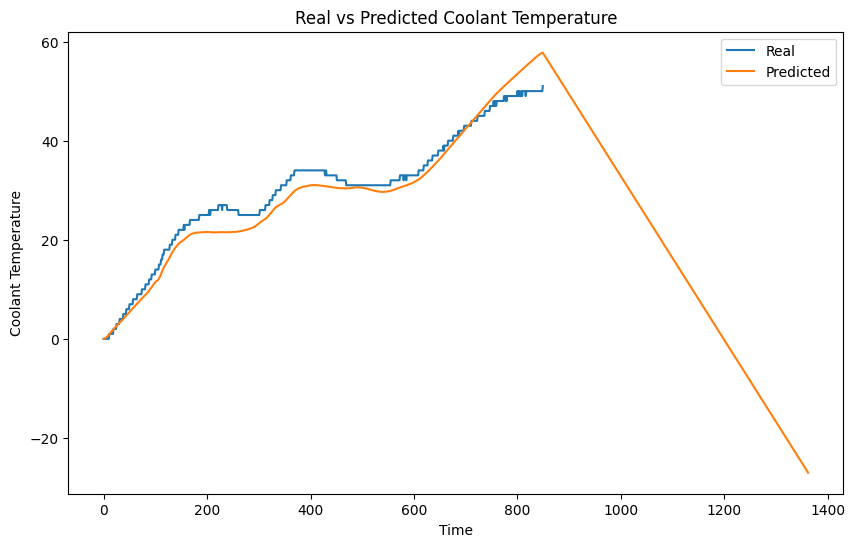

In [ ]:
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Function to process each file
def process_file(file_path):
    df = pd.read_csv(file_path)
    df['time'] = df['time'] - df['time'].iloc[0]
    df['Momentary Coolant change rate'] = df['Coolant_temperature'].diff().fillna(0)
    features = df[['Engine_speed', 'Throttle_position', 'Accelerator_pedal_position']]
    target = df['Momentary Coolant change rate']
    return features.values, target.values
    # return features.values

# Function to pad and normalize data
def pad_and_normalize(data, scaler, sequence_length):
    padded_data = pad_sequences(data, maxlen=sequence_length, dtype='float32', padding='post', truncating='post')
    normalized_data = scaler.transform(padded_data.reshape(-1, padded_data.shape[-1])).reshape(padded_data.shape)
    return normalized_data

# # Load the trained model and scalers
# model_path = '/content/gdrive/My Drive/modelBLSTM_lightoff_dynamic.h5'
# scaler_X_path = '/content/gdrive/My Drive/scaler_X.pkl'
# scaler_y_path = '/content/gdrive/My Drive/scaler_y.pkl'

model = model
scaler_X = scaler_X
scaler_y = scaler_y

# Path to new data for prediction
new_data_path = 'augmented_slice_106.csv'

# Process the new data
X_new, y_real = process_file(new_data_path)
# X_new = process_file(new_data_path)

# Normalize and pad the new data
X_new_normalized = scaler_X.transform(X_new)
X_new_padded = pad_sequences([X_new_normalized], maxlen=model.input_shape[1], dtype='float32', padding='post', truncating='post')

# Predict
y_pred = model.predict(X_new_padded)

# Reverse normalization
# y_real_rescaled = scaler_y.inverse_transform(y_real.reshape(-1, 1)).flatten()
y_pred_rescaled = scaler_y.inverse_transform(y_pred.flatten().reshape(-1, 1)).flatten()

# Plot real vs predicted
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(y_real,axis=0), label='Real')
plt.plot(np.cumsum(y_pred_rescaled[:len(y_real_rescaled)], axis=0), label='Predicted')
plt.legend()
plt.title('Real vs Predicted Coolant Temperature')
plt.xlabel('Time')
plt.ylabel('Coolant Temperature')
# plt.savefig(f'{PLOT_SAVE_DIR}/real_vs_predicted_new_data.png')
plt.show()
# print(y_pred_rescaled[:len(y_real_rescaled)])